In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [2]:
import h5py
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Flatten, Dense, Reshape, Conv3DTranspose, BatchNormalization, Embedding, Multiply, Concatenate

from tensorflow.keras.models import Model, Sequential

In [3]:
img_x = 32
img_y = 32
img_z = 32
channels = 1

# 입력 이미지 차원
img_shape = (img_x, img_y, img_z, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
latent_dim = 100

In [4]:
def build_discriminator(img_shape):
    # 입력 이미지 shape : input_shape
    input_image = Input(shape=img_shape)

    # Convolutional layers
    x = Conv3D(32, (3, 3, 3), strides=(2, 2, 2), padding='same')(input_image)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv3D(128, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv3D(256, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Flatten
    x = Flatten()(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # 모델 생성
    model = tf.keras.Model(inputs=input_image, outputs=output, name='discriminator')

    return model

In [5]:
def build_generator(z_dim):
    input_layer = Input(shape=z_dim)
    x = Dense(512*4*4*4, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((4, 4, 4, 512))(x)
    x = Conv3DTranspose(256, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv3DTranspose(128, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv3DTranspose(1, (3, 3, 3), strides=(1, 1, 1), padding='same', use_bias=False, activation='tanh')(x)
    model = tf.keras.Model(input_layer, x)
    return model

In [6]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [7]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(latent_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 16, 16, 16, 32)    896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 8, 8, 64)       55360     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 8, 64)       0         
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 4, 4, 128)      221312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 4, 128)    

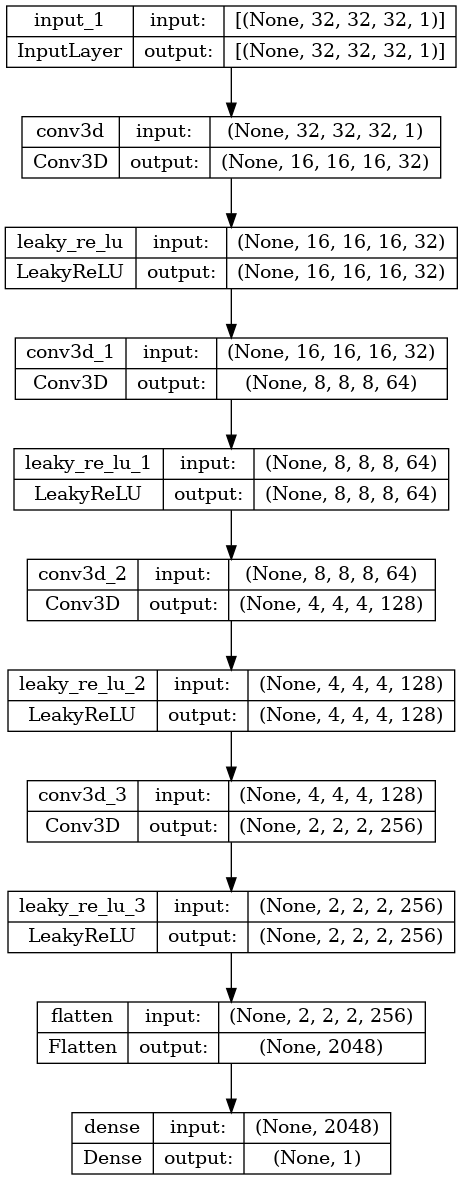

In [10]:
from tensorflow.keras.utils import plot_model

discriminator.summary()
plot_model(discriminator, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 32768)             3276800   
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 4, 512)      0         
                                                                 
 conv3d_transpose (Conv3DTra  (None, 8, 8, 8, 256)     3538944   
 nspose)                                                     

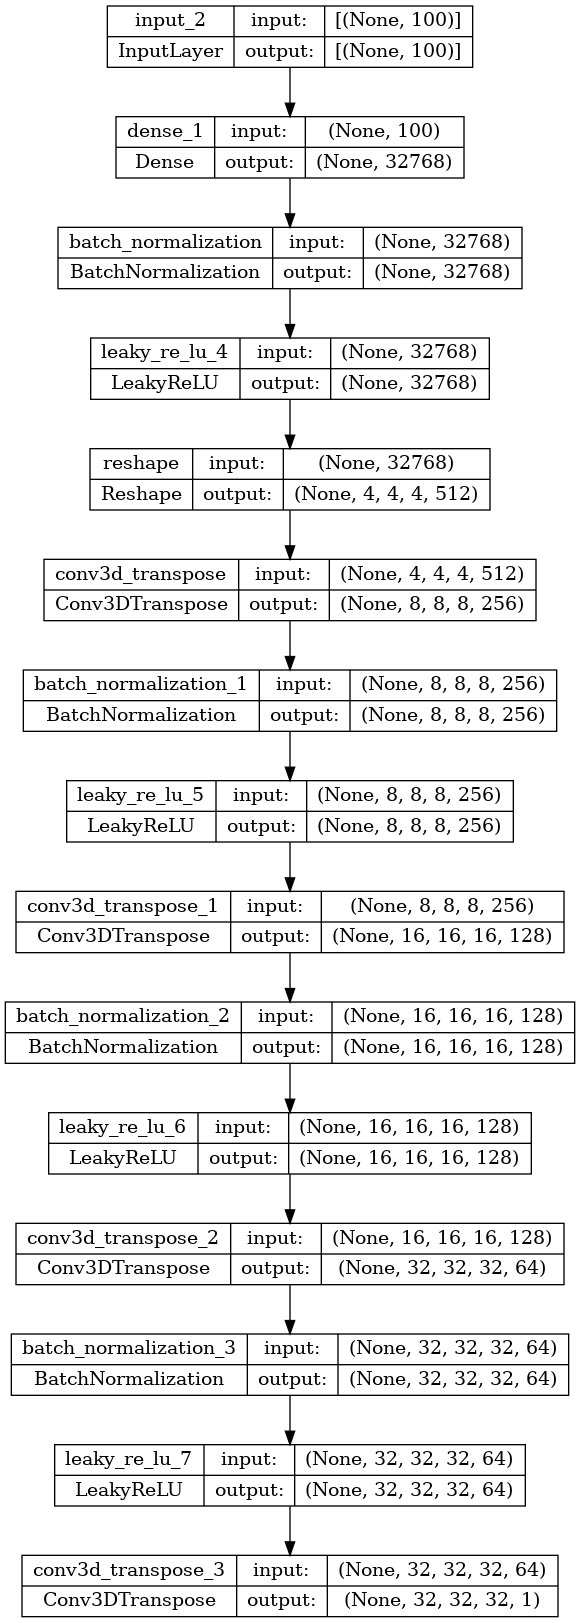

In [11]:
from tensorflow.keras.utils import plot_model

generator.summary()
plot_model(generator, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 32, 32, 32, 1)     8056256   
                                                                 
 discriminator (Functional)  (None, 1)                 1164609   
                                                                 
Total params: 9,220,865
Trainable params: 7,989,824
Non-trainable params: 1,231,041
_________________________________________________________________


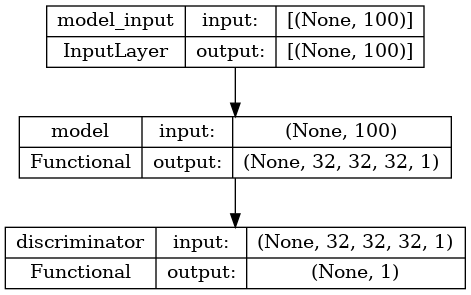

In [12]:
gan.summary()
plot_model(gan, show_shapes=True)

In [14]:
import h5py

# Open the file
with h5py.File('./ModelNet40vox32_airplane.h5', 'r') as f:
    data = f['data'][:-22]

print("Data shape:", data.shape)

# Batch the data and shuffle
batch_size = 32

# Specify the dtype of the data
dtype = tf.float32

# Convert the data array to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices(tf.cast(data, dtype=dtype))
dataset = dataset.shuffle(buffer_size=len(data)).batch(batch_size)

print(dataset.element_spec)

Data shape: (704, 32, 32, 32, 1)
TensorSpec(shape=(None, 32, 32, 32, 1), dtype=tf.float32, name=None)


In [15]:
import numpy as np

def train_gan(gan, dataset, batch_size, latent_dim, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, latent_dim])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        save_dir = 'generated_vox32_samples'
        os.makedirs(save_dir, exist_ok=True)  # 새로운 폴더 생성
        num_samples = 20
        random_noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
        generated_samples = generator(random_noise)
        filename = f'generated_sample_{epoch + 1}.npy'
        filepath = os.path.join(save_dir, filename)
        np.save(filepath, generated_samples)

In [ ]:
train_gan(gan, dataset, batch_size, latent_dim, n_epochs=50)

In [ ]:
checkpoint = tf.train.Checkpoint(model=generator)
checkpoint.save("generator.ckpt")

In [ ]:
discriminator.save('pcd2048_40_230507_01_discriminator.h5')
generator.save('pcd2048_40_230507_01_generator.h5')
gan.save('pcd2048_40_230507_01_gan.h5')

In [ ]:
import matplotlib.pyplot as plt

num_samples = 20
random_noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
generated_samples = generator(random_noise)

# 시각화에 필요한 변수 설정
num_row = 4
num_col = 5

# 생성된 샘플들 중 일부만 선택
selected_samples = generated_samples[:num_row * num_col]

# 시각화할 전체 그림 크기 설정
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Generated Samples', fontsize=20) # 전체 제목 설정


# 각 셀에 3D 볼륨을 시각화하여 배치
for i in range(num_row * num_col):
    # 현재 셀 위치 계산
    ax = fig.add_subplot(num_row, num_col, i+1, projection='3d')
    
    # 3D 볼륨 시각화
    ax.voxels(selected_samples[i, :, :, :, 0], edgecolor='k')
    ax.set(xticks=[], yticks=[], zticks=[])
    ax.set_title(f'Sample {i+1}')

# 그림 출력
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

load_pcd = np.load('./generated_pcd_500.npy')
# 데이터와 라벨 로드
data = load_pcd
# label = load_pcd['label']

# subplot 행과 열 설정
num_plots_row = 1
num_plots_col = 5

# 전체 플롯 설정
fig = plt.figure(figsize=(20, 4))
fig.suptitle('1', fontsize=20) # 전체 제목 설정

# 각각의 subplot 생성
for i in range(num_plots_row*num_plots_col):
    ax = fig.add_subplot(num_plots_row, num_plots_col, i+1, projection='3d')
    plot_data = data[i]
    # plot_label = label[i]
    
    # scatter plot 생성
    ax.scatter(plot_data[:, 0], plot_data[:, 1], plot_data[:, 2])
    # 축 범위 설정
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    # 축 옆의 숫자 없애기
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # # 제목 설정
    # label_name = list(categories.keys())[list(categories.values()).index(plot_label[0])]
    # plt.title(f'{label_name}')
    
# 플롯 보여주기
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

for n in range(500):
    filenum = n + 1
    load_pcd = np.load(f'./generated_pcd_{filenum}.npy')
    # 데이터와 라벨 로드
    data = load_pcd
    # label = load_pcd['label']

    # subplot 행과 열 설정
    num_plots_row = 1
    num_plots_col = 5

    # 전체 플롯 설정
    fig = plt.figure(figsize=(20, 4))
    fig.suptitle(f'Epoch {filenum}/500', fontsize=20) # 전체 제목 설정

    # 각각의 subplot 생성
    for i in range(num_plots_row*num_plots_col):
        ax = fig.add_subplot(num_plots_row, num_plots_col, i+1, projection='3d')
        plot_data = data[i]
        # plot_label = label[i]
        
        # scatter plot 생성
        ax.scatter(plot_data[:, 0], plot_data[:, 1], plot_data[:, 2])
        # 축 범위 설정
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_zlim([0, 1])
        # 축 옆의 숫자 없애기
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
        # # 제목 추가
        # ax.set_title(f"Label: {plot_label[0]}")
        # # 제목 설정
        # label_id = np.argmax(label[i])
        # label_name = list(categories.keys())[list(categories.values()).index(label_id)]
        # plt.title(f'{label_name}')
        
    # # 플롯 보여주기
    # plt.show()
    # 그래프 저장
    plt.savefig(f"Epoch{filenum}.png")
    plt.clf()
    plt.close()
    print(filenum)

In [ ]:
import imageio
import os

# 이미지 파일 경로 설정
img_dir = '/home/yoobh/ws/MastersThesis/ModelNet5_pcd_DCGAN_230508_01/final/'

# 이미지 파일 리스트 생성
# img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')]
img_files = []

for i in range(500):
    filenum = i + 1
    file_name = f"Epoch{filenum}.png"
    file_path = os.path.join(img_dir, file_name)
    img_files.append(file_path)

In [ ]:
# img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])

In [ ]:
img_files

In [ ]:
# 이미지 시퀀스를 영상으로 변환
with imageio.get_writer('output.mp4', fps=5) as writer:
    for img_file in img_files:
        img = imageio.imread(img_file)
        writer.append_data(img, duration=0.2)

In [ ]:
# 이미지 시퀀스를 영상으로 변환
images = []
for img_file in img_files:
    images.append(imageio.imread(img_file))

# 영상 파일로 저장
imageio.mimsave('output3.mp4', images, fps=5)